# Racetrack Problem
## Exercise 5.12

Consider driving a race car around a turn
like those shown in Figure 5.5. You want to go as fast as possible, but not so fast as
to run off the track. 

In our simplified racetrack, the car is at one of a discrete set of
grid positions, the cells in the diagram. The velocity is also discrete, a number of grid
cells moved horizontally and vertically per time step. The actions are increments to the
velocity components. Each may be changed by +1, 1, or 0 in each step, for a total of
nine (3 x 3) actions. Both velocity components are restricted to be nonnegative and less
than 5, and they cannot both be zero except at the starting line. Each episode begins
in one of the randomly selected start states with both velocity components zero and
ends when the car crosses the finish line. The rewards are 1 for each step until the car
crosses the finish line. If the car hits the track boundary, it is moved back to a random
position on the starting line, both velocity components are reduced to zero, and the episode continues.

Before updating the car’s location at each time step, check to see if
the projected path of the car intersects the track boundary. If it intersects the finish line,
the episode ends; if it intersects anywhere else, the car is considered to have hit the track
boundary and is sent back to the starting line. To make the task more challenging, with
probability 0.1 at each time step the velocity increments are both zero, independently of
the intended increments. Apply a Monte Carlo control method to this task to compute
the optimal policy from each starting state. Exhibit several trajectories following the
optimal policy (but turn the noise off for these trajectories).

Episode: 0
Episode: 10000
Episode: 20000
Episode: 30000
Episode: 40000


<IPython.core.display.Javascript object>


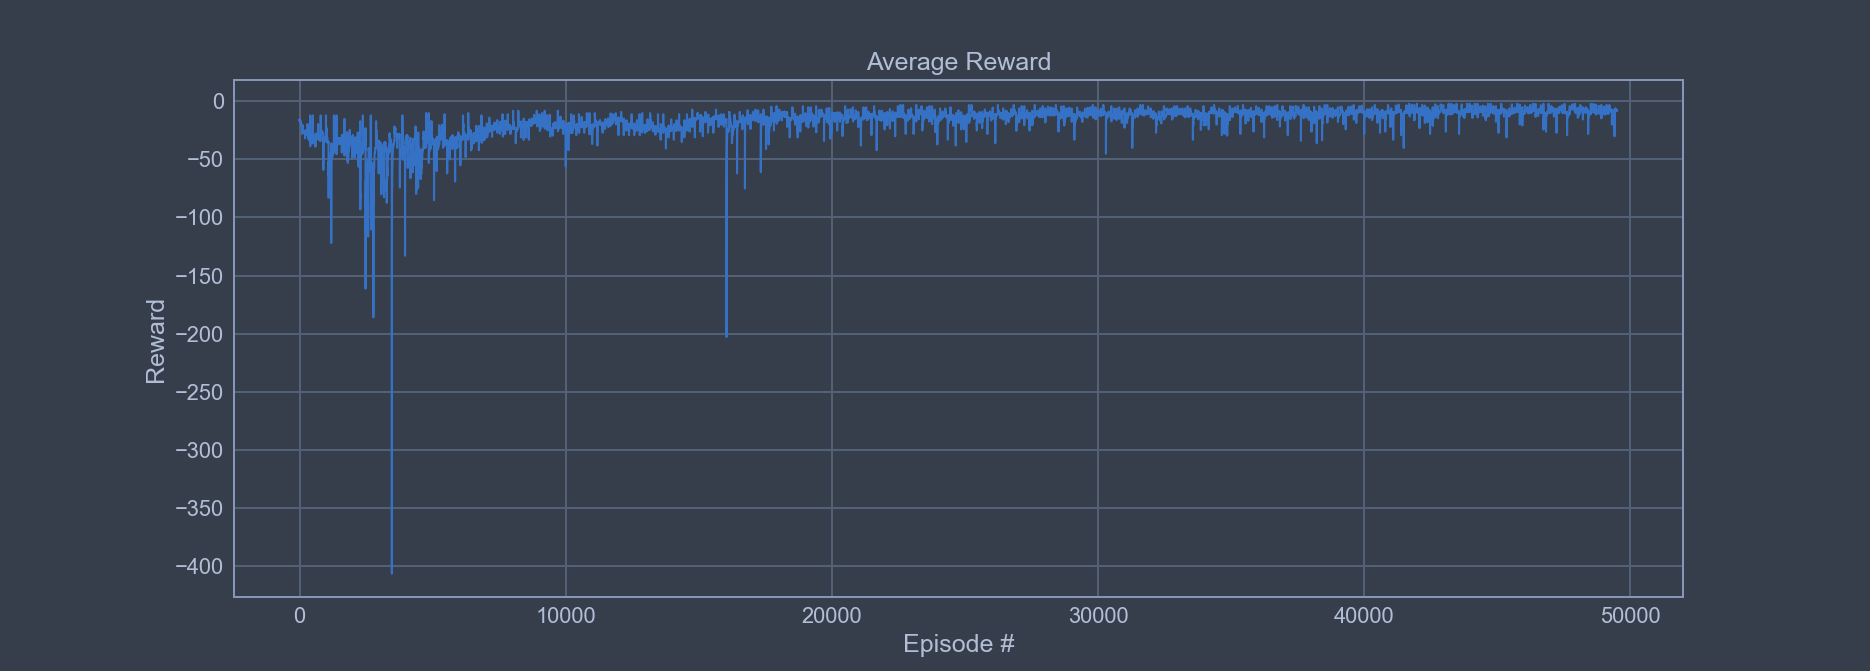

<IPython.core.display.Javascript object>


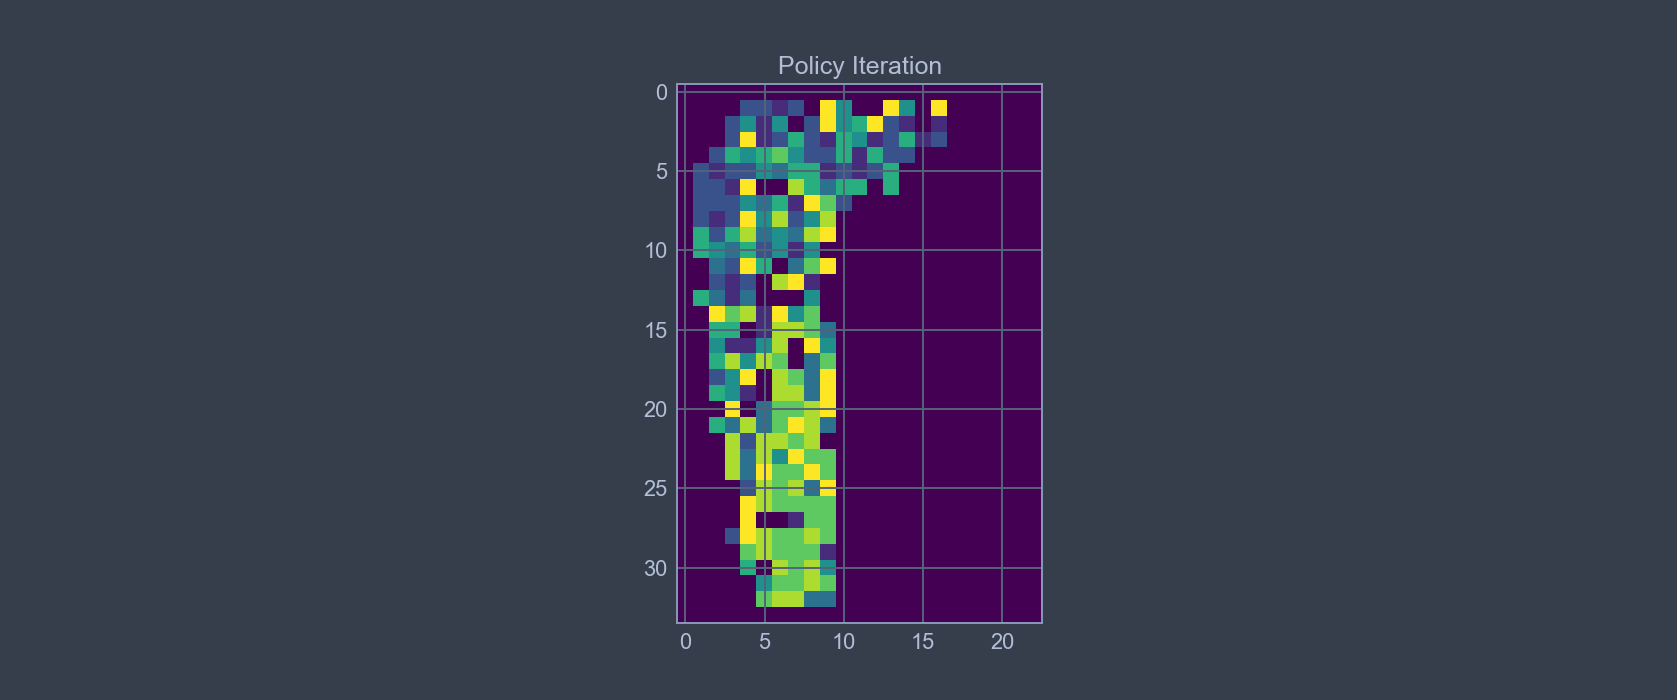

<IPython.core.display.Javascript object>


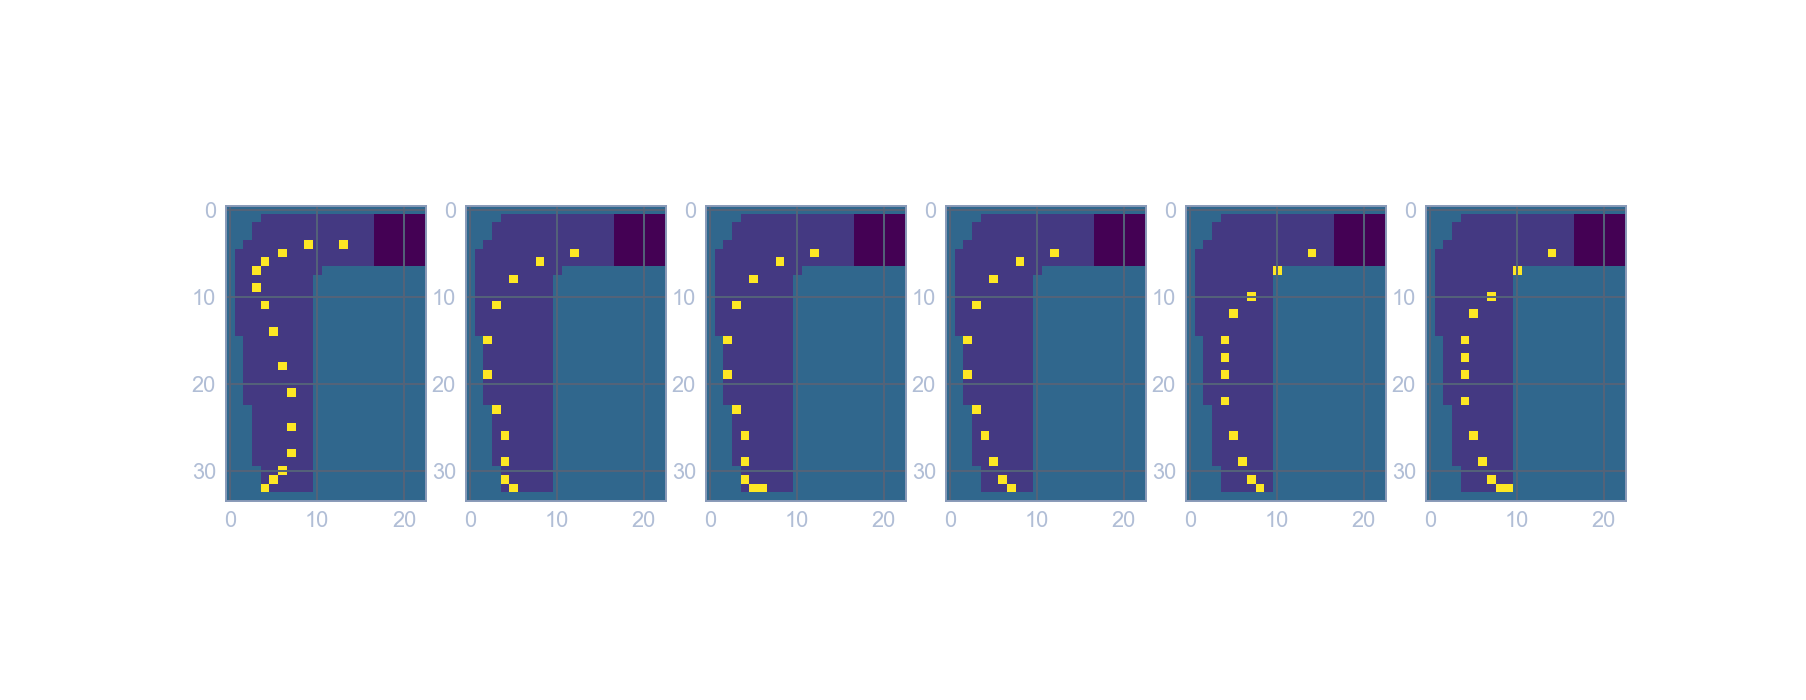

-11.333333333333334


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import warnings
warnings.simplefilter('error', RuntimeWarning)

from jupyterthemes import jtplot
jtplot.style()

%matplotlib notebook


def make_track():
    """
    Make racetrack #1 as shown in textbook
    
    Parameters
    ----------
        None
          
    Returns
    -------
    list
        List of tuples for potential initial positions
    ndarray
        A racetrack represented using an array
        0 :  The track
        1 :  Out of bounds
        -1 : Finish area
    """
    track = np.zeros((34, 23))
    track[33, :] = 1
    track[:, 0] = 1
    track[0, :] = 1
    track[:5, 1] = 1
    track[:4, 2] = 1
    track[:2, 3] = 1
    track[15:, 1] = 1
    track[23:, 2] = 1
    track[30:, 3] = 1
    track[8:, 10] = 1
    track[7:, 11:] = 1
    track[1:7, 17:] = -1
    start = [(32, 4), 
             (32, 5), 
             (32, 6), 
             (32, 7), 
             (32, 8), 
             (32, 9)]

    return start, track

def map_to_deltav(action_idx):
    """
    Map action index (0 to 8) to delta-v
    
    Parameters
    ----------
        action_idx : int
            The action to be taken
            
    Returns
    -------
    tuple 
        delta-v represented in tuple
    """
    return [(-1,1), 
            (1,0), 
            (1,1), 
            (0,-1), 
            (0,0), 
            (0,1), 
            (-1,-1), 
            (-1,0), 
            (1,-1)][action_idx]

def check_intersection(track, a, b, value):
    """
    Checks if line formed by (a, b) intersects area with value given track
    
    Parameters
    ----------
        track : ndarray
            Racetrack
        a : ndarray
            Point a
        b : ndarray
            Point b
        value : float
            Value on the track to check for
            
    Returns
    -------
    boolean
        whether line (a, b) intersects area with value
    """
    points = np.linspace(tuple(a),tuple(b),int(np.abs(np.linalg.norm(b-a)))+2)
    for pt in points:
        if (track[tuple(np.round(pt).astype(int))] == value):
            return True
    return False

def generate_episode(start, track, policy):
    """
    Generate an episode from policy and environment
    
    Instead of ending episode at the finish, end 
        episode if off-track or at finish. Shape
        behavior with punishments and rewards
    
    Parameters
    ----------
        start : ndarray
            Array of tuples for starting locations
        track : ndarray
            Racetrack
        policy : func
            function mapping position to action index
            
    Returns
    -------
    ndarray 
        Trajectory of states of length T = #steps
    ndarray
        Rewards, length T + 1
    ndarray
        Actions taken, length T
    ndarray
        Action probabilities, length T
    """
    velocity = np.array([0, 0])
    states = []
    rewards = [0] # maintain consistent indexing
    actions = []
    action_probs = []
    position = np.array(list(random.choice(start)))
    crash_count = 0
    prev_position = position
    
    while True:
        states.append(position.copy())
        action, pr = policy(tuple(position))
        actions.append(action)
        action_probs.append(pr)
        dv = map_to_deltav(action)
        velocity += dv
        bad_action = False
        
        if ((velocity[0] == 0 and dv[0] == 1) or (velocity[1] == 0 and dv[1] == -1)):
            bad_action = True
        velocity[0] = min(max(velocity[0], -5), 1)
        velocity[1] = min(max(velocity[1], -1), 5)
        if (velocity[0] == 0 and velocity[1] == 0):
            velocity[1] = 1
            bad_action = True
        position += velocity
        position[0] = min(max(position[0], 0), 33)
        position[1] = min(max(position[1], 0), 22)
        
        if (check_intersection(track, prev_position, position, 1.0)):
            rewards.append(-12.0)
            return (np.array(states, dtype=int), 
                    np.array(rewards, dtype=int), 
                    np.array(actions, dtype=int), 
                    np.array(action_probs, dtype=float))

        elif (check_intersection(track, prev_position, position, -1.0)):
            rewards.append(12.0)
            return (np.array(states, dtype=int), 
                    np.array(rewards, dtype=int), 
                    np.array(actions, dtype=int), 
                    np.array(action_probs, dtype=float))
        
        if bad_action:
            rewards.append(-3)
        elif position[0] < 20:
            rewards.append(-1)
        else:
            rewards.append(-2)
            
        prev_position = position
        
def train(trackinfo):
    """
    Estimate optimal policy using off-policy Monte-Carlo
    
    Parameters
    ----------
        trackinfo : tuple
            Information about racetrack (start, track)
            
    Returns
    -------
    list
        Every 100th policy & last policy
    ndarray
        Estimated action-values, shape=(track-i, track-j, 9)
    ndarray
        Average rewards grouped every 100 episodes
    """
    N_episodes = 50000
    epsilon = 0.03
    gamma = 0.7
    start, track = trackinfo
    Q = np.zeros(tuple(list(track.shape) + [9]))
    C = np.zeros(tuple(list(track.shape) + [9]))
    pi = np.zeros(tuple(track.shape), dtype=int)
    pis = []
    reward_avgs = []
    
    for i in range(track.shape[0]):
        for j in range(track.shape[1]):
            pi[i, j] = np.argmax(Q[i, j])
            
    def make_soft_policy(pi, epsilon):
        def b(position):
            rand = random.uniform(0, 1)
            non_greedy = [0,1,2,3,4,5,6,7,8]
            greedy = pi[position]
            if (rand < epsilon):
                return random.choice(non_greedy), epsilon / len(non_greedy)
            else:
                return greedy, 1 - epsilon + epsilon / len(non_greedy)
        return b
    
    reward_avg = 0
    for n in range(N_episodes):
        b = make_soft_policy(pi, epsilon)
        states, rewards, actions, action_prob = generate_episode(start, track, b)
        reward = np.sum(rewards)
        T = len(states)
        G = 0.0
        W = 1.0
        SA = [tuple(np.append(state, action)) for state, action in zip(states, actions)]
        
        if (n % 10000 == 0):
            print('Episode: {}'.format(n))
        
        if (n % 100 == 0):
                reward_avg = reward
                pis.append(pi.copy())
        else:
            reward_avg = reward_avg + 1/(n % 100) * (reward - reward_avg)
            reward_avgs.append(reward_avg)
            
        for t in range(0, T):
            t = T-t-1
            SAt = SA[t]
            G = gamma * G + rewards[t + 1]
            C[SAt] = C[SAt] + W
            Q[SAt] = Q[SAt] + W * (G - Q[SAt]) / C[SAt]
            pi[SAt[:2]] = np.argmax(Q[SAt[:2]])
            
            if SAt[-1] != pi[SAt[:2]]:
                break
            else:
                W = W / action_prob[t]
                
    pis.append(pi.copy())
    return pis, Q, reward_avgs

def validate_policy(track, policy, start):
    states = []
    actions = []
    rewards = []
    position = start
    velocity = np.array([0,0])
    prev_position = position
    
    while True:
        states.append(position.copy())
        action = policy[tuple(position)]
        actions.append(action)
        velocity += map_to_deltav(action)
        velocity[0] = min(max(velocity[0], -5), 1)
        velocity[1] = min(max(velocity[1], -1), 5)
        if (velocity[0] == 0 and velocity[1] == 0):
            print('control')
            velocity[1] = 1
        position += velocity
        position[0] = min(max(position[0], 0), 33)
        position[1] = min(max(position[1], 0), 22)

        if (check_intersection(track, prev_position, position, 1.0)):
            rewards.append(0.0)
            print('fail')
            return (np.array(states, dtype=int), 
                    np.sum(np.array(rewards, dtype=int)), 
                    np.array(actions, dtype=int))

        elif (check_intersection(track, prev_position, position, -1.0)):
            rewards.append(0.0)
            return (np.array(states, dtype=int), 
                    np.sum(np.array(rewards, dtype=int)), 
                    np.array(actions, dtype=int))
        rewards.append(-1.0)
        prev_position = position
        
if __name__ == '__main__':
    start, track = make_track()
    pis, Q, reward_avgs = train((start, track))
    pi = pis[-1]
    pi_imgs = []
    
    plt.figure()
    plt.plot(reward_avgs)
    plt.title('Average Reward')
    plt.xlabel('Episode #')
    plt.ylabel('Reward')

    fig = plt.figure()
    for n, p in enumerate(pis):
        if n < 300:
            im = plt.imshow(p, animated=True)
            pi_imgs.append([im])
        else:
            break
        
    ani = animation.ArtistAnimation(fig, pi_imgs, interval=100, blit=True, repeat_delay=500)  
    plt.show()
    plt.title('Policy Iteration')
    
    rewards = 0
    fig, axs = plt.subplots(1,len(start), facecolor='w', edgecolor='k')
    for i, s in enumerate(start):
        s = np.array(list(s))
        states, reward, actions = validate_policy(track, pi, s)
        rewards += reward
        track_trace = track.copy()
        for s in states:
            track_trace[tuple(s)] = 5
        axs[i].imshow(track_trace)
    print(rewards/len(start))
    